In [1]:
from quantum_electron import FullModel, PotentialVisualization
from quantum_electron.utils import xy2r, r2xy, density_from_positions
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me
from alive_progress import alive_bar

In [2]:
import zeroheliumkit

# Create the potential

In [3]:
# Note that the units of x and y are implicitly assumed as microns
channel_length = 80 # microns
x = np.linspace(-channel_length/2., channel_length/2., 301)
y = np.linspace(-4, 4, 201)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

parabolic_channel = - Y ** 2 / micron ** 2

channel_width = 3e-6
parabolic_channel[np.abs(Y) > channel_width / 2] = - (channel_width/2) ** 2 / micron ** 2

# The parameter in front of R - R0, tunes how sharp the boundary is.
end_caps = 4 * (-1 - 0.5 * ( -np.tanh(5 * (X + (channel_length/2 - 2) * micron) / micron) + np.tanh(5 * (X - (channel_length/2 - 2) *micron) / micron)))
parabolic_channel += end_caps

# also add the guard ring
gnd_plane = np.ones(X.shape)
gnd_plane[np.abs(Y) < channel_width / 2] = 0 

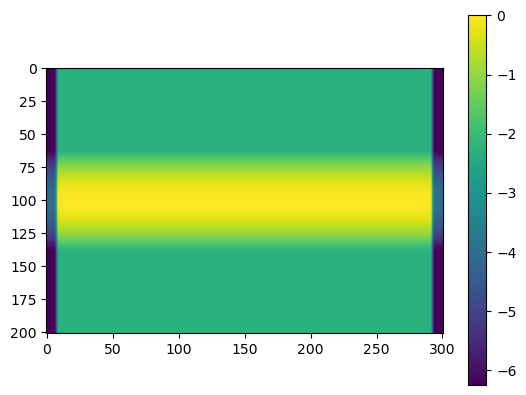

In [4]:
plt.imshow(parabolic_channel)
plt.colorbar()

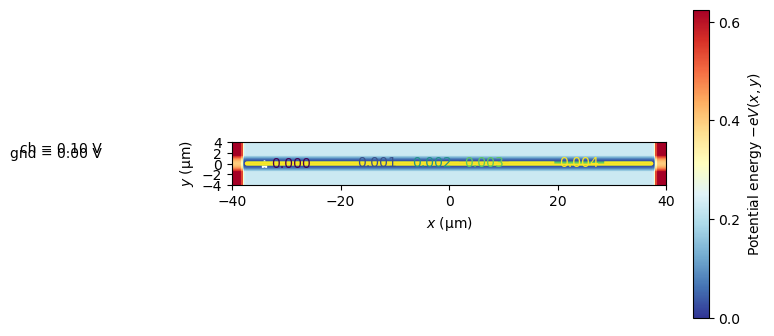

In [5]:
potential_dict = {"ch" : parabolic_channel.T, 
                  "gnd" : gnd_plane.T, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"ch" : 0.1, 
            "gnd" : 0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(channel_length, 8))

# Adding electrons

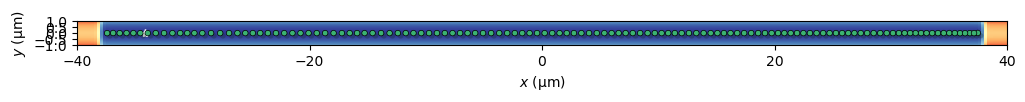

In [64]:
n_electrons = 225

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
n_rows = 1
init_x = np.tile(np.linspace(-channel_length+1.5, channel_length-1.5, n_electrons // n_rows), n_rows) * micron
init_y = np.repeat(np.linspace(-.8, 8, n_rows), n_electrons // n_rows) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

In [65]:
density_from_positions(final_x, final_y) / 1e13

0.3551420987830366

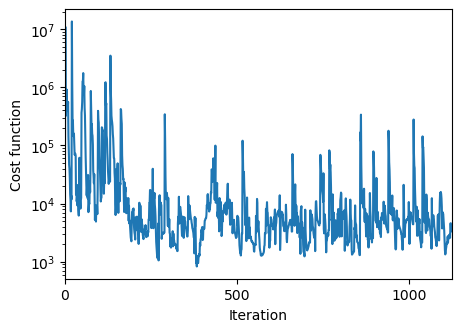

In [66]:
fm.plot_convergence()

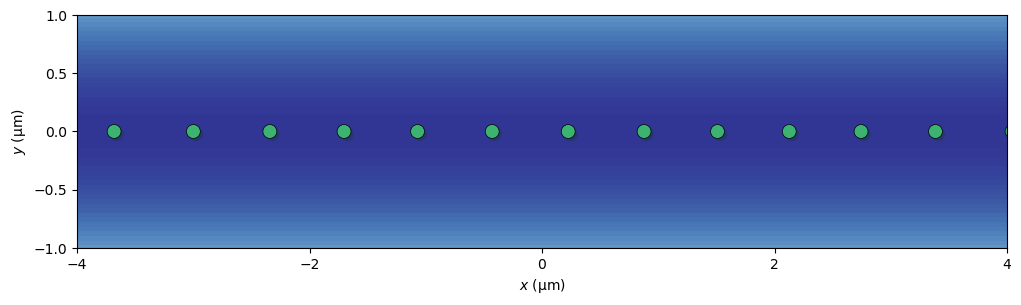

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

# Eigenmodes

In [9]:
print("Trap curvature for electrons is", 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['ch'] / micron ** 2 / me), "GHz")

Trap curvature for electrons is 29.850102621705076 GHz


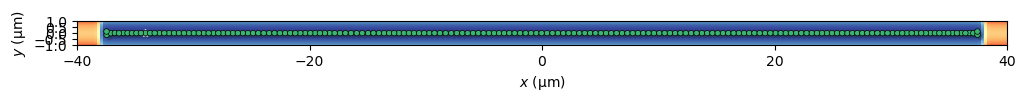

In [88]:
n_electrons = 300
n_plots = 5

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*5, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
n_rows = 1
init_x = np.tile(np.linspace(-channel_length+1.5, channel_length-1.5, n_electrons // n_rows), n_rows) * micron
init_y = np.repeat(np.linspace(-.8, 8, n_rows), n_electrons // n_rows) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)



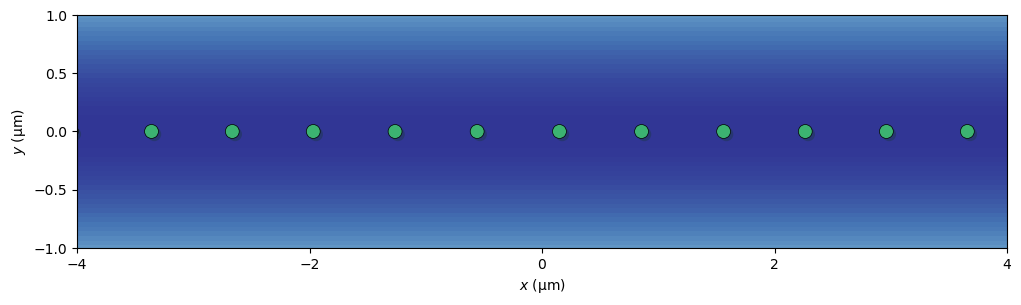

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

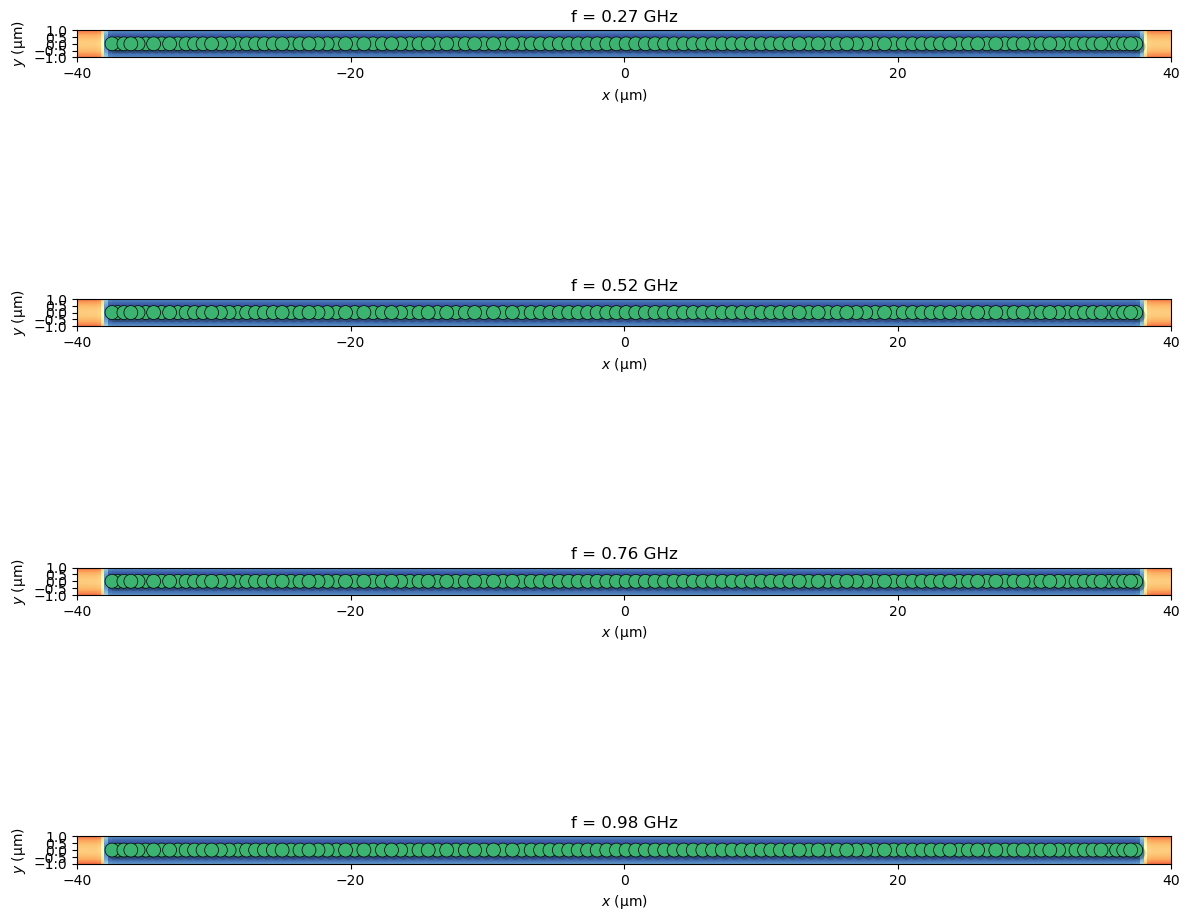

In [80]:
n_plots = 4

fig, ax = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots))
fm.set_rf_interpolator(rf_electrode_labels=['ch'])

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)
    # fm.plot_electron_positions(res, ax=ax[n])

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'])
    efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=False)

    # fm.plot_eigenvector(res['x'], evecs[:, n])

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    
fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'])

In [81]:
fm.show_animation(anim)

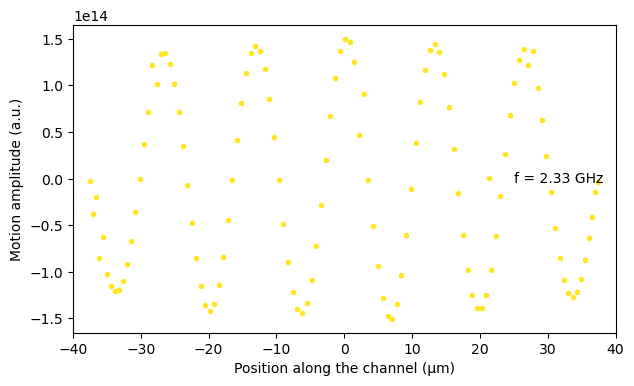

In [82]:
m = len(final_x)

fig = plt.figure(figsize=(7, 4.))
for mode_idx in range(10, 11):
    plt.plot(final_x / micron, evecs.T[mode_idx][1:m+1], '.', color=plt.cm.viridis(mode_idx / 6), label=f"f = {efreqs[mode_idx]/1e9:.2f} GHz")
plt.xlim(-channel_length/2, channel_length/2)
plt.xlabel(f"Position along the channel ({chr(956)}m)")
plt.ylabel("Motion amplitude (a.u.)")
plt.legend(loc=0, frameon=False)

In [83]:
chain_length = channel_length * micron - 4e-6
a = chain_length / (m+1)

omega_zero = np.sqrt((qe ** 2 / (4 * np.pi * eps0 * me * a ** 3))) / (2 * np.pi)

In [84]:
m

115

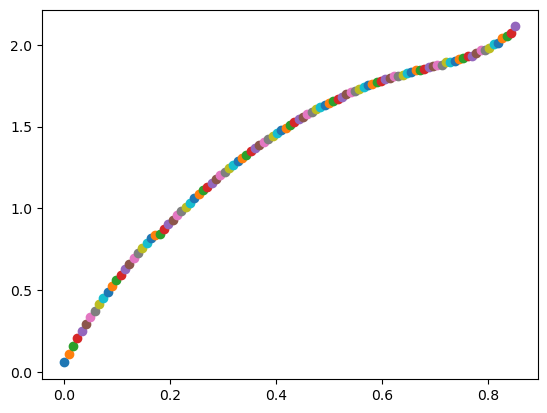

In [87]:
for k_idx in range(m-10):
    k = k_idx * np.pi / (channel_length * micron)
    plt.plot(k * a / np.pi, efreqs[k_idx] / omega_zero, 'o')

In [39]:
xi, yi = r2xy(res['x'])
n_s = density_from_positions(xi, yi)
print(f"Density = {n_s:.2e} m^-2")

Density = 1.12e+13 m^-2


In [40]:
k = np.pi / (channel_length * micron)

w_e = 2 * np.max(final_y)
channel_width - w_e
channel_depth = 1e-6

F_x = 1 #np.tanh(k * (channel_width - w_e)) + np.tanh(k * channel_depth)

f_theory = np.sqrt(n_s * qe ** 2 * np.sqrt(k ** 2 * F_x) / (2 * eps0 * me)) / (2 * np.pi)

print(f_theory / 1e9)

4.21397096002554


In [45]:
a = 2e-6 / 6.5
np.sqrt(4 * (2 * qe ** 2 / (4 * np.pi * eps0 * me * a ** 3))) / (2 * np.pi * 1e9)

41.97365278052221

In [32]:
4 * np.pi * 1e12 * qe ** 2 * np.pi / 1e-2 / me

111247824.9215119

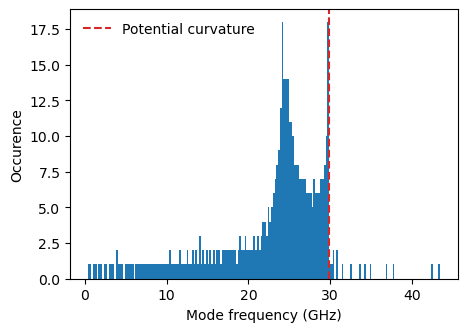

In [42]:
trap_curvature = 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['ch'] / micron ** 2 / me)

fig = plt.figure(figsize=(5., 3.5))
plt.hist(efreqs/1e9, bins=200)
plt.axvline(trap_curvature, linestyle='--', color='tab:red', label="Potential curvature")
plt.xlabel("Mode frequency (GHz)")
plt.ylabel("Occurence")

plt.legend(loc=0, frameon=False)